# Importing the necessary libraries

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import timedelta
import pickle
import gzip



# cleaning up the dataset for auto_arima prediction
### Considering the high seasonality of sun cycles, trying to use auto_arima vs ARIMA

In [11]:
solar_cycle = pd.read_csv('../data/solar_cycle.csv')

columns_to_drop = ['smoothed_ssn', 'observed_swpc_ssn', 'smoothed_swpc_ssn', 'smoothed_f10.7']
solar_cycle = solar_cycle.drop(columns=columns_to_drop)

training  = solar_cycle.iloc[:-120,:] #training stop 01-01-1980
test = solar_cycle.iloc[-120:,:]

In [12]:
# model = auto_arima(y = training.ssn, m = 12) #12 months x 11 years

# prediction = pd.Series(model.predict(n_periods= len(test)))

# predictions_df = pd.DataFrame({'ssn': prediction.values}, index=test.index)

In [13]:
# # Filter data starting from 1980
# start_date = '1980-01-01'
# filtered_training = training[start_date:]
# filtered_test = test[start_date:]
# filtered_predictions = predictions_df[start_date:]

# # Plot 'ssn' from the filtered training and test sets
# plt.figure(figsize=(12, 8))
# filtered_training['ssn'].plot(legend=True, label='Training Data')
# filtered_test['ssn'].plot(legend=True, label='Test Data')

# # Plot 'ssn' predictions
# filtered_predictions['ssn'].plot(legend=True, label='Predictions', linestyle='dashed')

# plt.xlabel('Time')
# plt.ylabel('SSN')
# plt.title('Training, Test, and Prediction Data (Starting from 1980)')
# plt.show()

# Auto-arima is not performing well for long-term prediction, testing SARIMA

In [14]:
import statsmodels.api as sm

solar_cycle['time_tag'] = pd.to_datetime(solar_cycle['time_tag'])
solar_cycle.set_index('time_tag', inplace=True)
solar_cycle.index.freq = 'MS'

# Define SARIMA model parameters
order = (3, 0, 10)            # (p, d, q)
seasonal_order = (1, 1, 0, 43)  # (P, D, Q, S)

# Create the SARIMA model
model = sm.tsa.SARIMAX(solar_cycle['ssn'], order=order, seasonal_order=seasonal_order, trend='n')

# Fit the SARIMA model to solar_cycle
results = model.fit()

#saving the model (model too large to be added in github, will not activate it for now, will not be added to github)

# with gzip.open('../models/sarima/compressed_sarima_model_solar_cycles.pkl.gz', 'wb') as model_file:
#     pickle.dump(model, model_file)

# Print the model summary
print(results.summary())

c:\Users\antho\Ironhack_workfiles\helios\env_helios\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  ssn   No. Observations:                 3300
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 43)   Log Likelihood              -15679.319
Date:                              Fri, 26 Jan 2024   AIC                          31388.638
Time:                                      16:34:58   BIC                          31479.966
Sample:                                  01-01-1749   HQIC                         31421.351
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2258      0.131      9.361      0.000       0.969       1.483
ar.L2          0.52

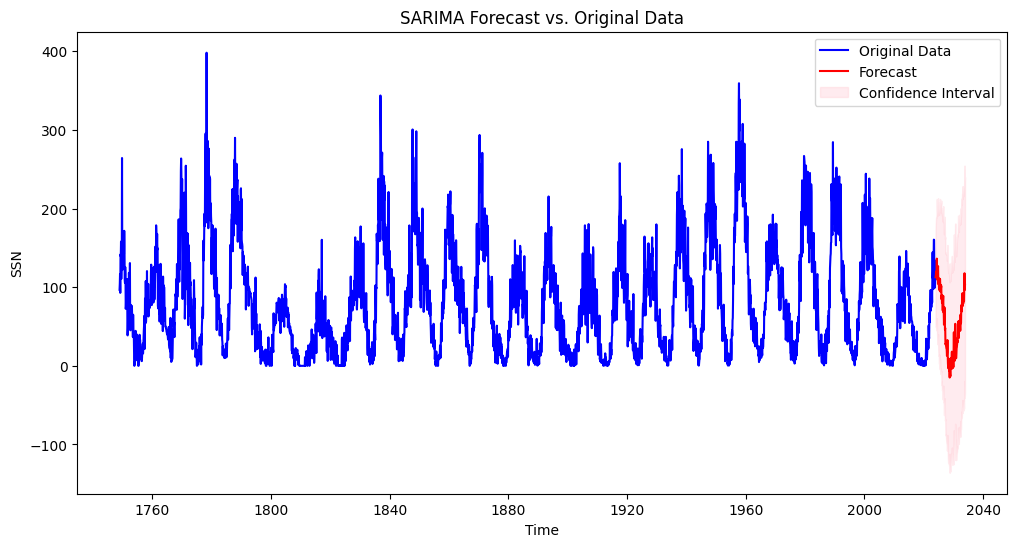

In [6]:

# Assuming you have already defined and fitted your SARIMA model as 'results'

# Define the number of periods to forecast (adjust as needed)
forecast_periods = 120  # next 10 years (120 months)

# Get the forecast and its confidence intervals
forecast = results.get_forecast(steps=forecast_periods)

# Extract the forecasted values and their confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(solar_cycle.index, solar_cycle['ssn'], label='Original Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int['lower ssn'], forecast_conf_int['upper ssn'], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast vs. Original Data')
plt.xlabel('Time')
plt.ylabel('SSN')
plt.legend()
plt.show()

2024-01-01    112.628113
2024-02-01    115.217627
2024-03-01    119.797781
2024-04-01    117.111581
2024-05-01    118.603184
                 ...    
2033-08-01     82.242370
2033-09-01    102.053541
2033-10-01    117.772472
2033-11-01     96.418377
2033-12-01    102.984787
Freq: MS, Name: predicted_mean, Length: 120, dtype: float64

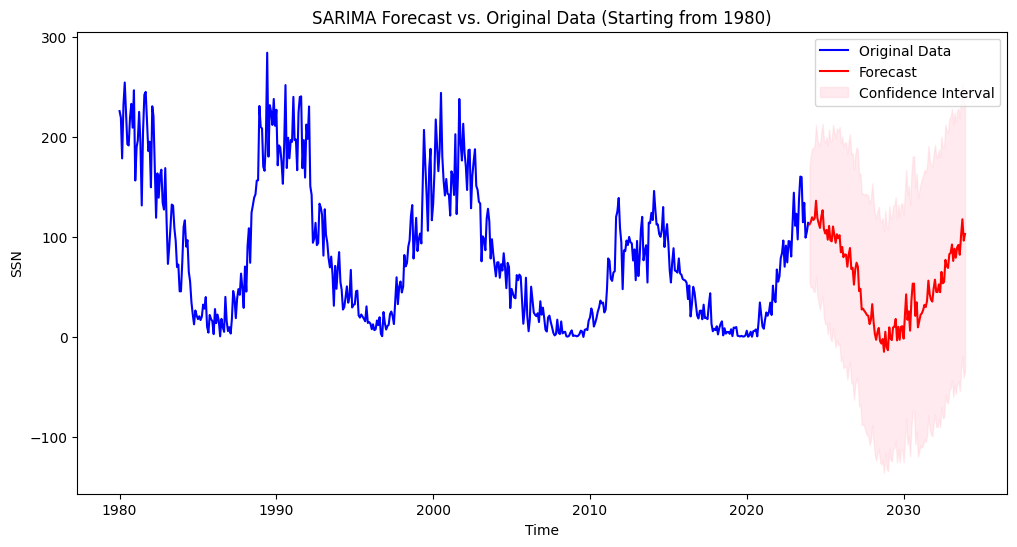

In [7]:
# Filter data starting from 1980 to have a better view of model's performance
start_date = '1980-01-01'
filtered_solar_cycle = solar_cycle[start_date:]

# Plot the original data and the forecast starting 1980
plt.figure(figsize=(12, 6))
plt.plot(filtered_solar_cycle.index, filtered_solar_cycle['ssn'], label='Original Data', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int['lower ssn'], forecast_conf_int['upper ssn'], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Forecast vs. Original Data (Starting from 1980)')
plt.xlabel('Time')
plt.ylabel('SSN')
plt.legend()
plt.show()

# Checking best hyperparameters to fine-tune SARIMA

In [8]:
#FYI >>> This took 48 hours on my computer  

#Define SARIMA model parameters
# p = d = q = range(0, 3)  # Define the range of p, d, and q values
# seasonal_pdq = [(x[0], x[1], x[2], 43) for x in list(itertools.product(p, d, q))]  # Define seasonal p, d, q values

# best_aic = np.inf  # Initialize the best AIC value as infinity
# best_order = None
# best_seasonal_order = None

# for param in itertools.product(p, d, q):
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(
#                 solar_cycle['ssn'],
#                 order=param,
#                 seasonal_order=param_seasonal,
#                 enforce_stationarity=False,
#                 enforce_invertibility=False,
#             )
#             results = mod.fit()
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = param
#                 best_seasonal_order = param_seasonal
#         except:
#             continue

# # Print the best hyperparameters
# print("Best SARIMA Order:", best_order)
# print("Best Seasonal Order:", best_seasonal_order)
# print("Best AIC:", best_aic)

# Saving prediction as a CSV

In [21]:
forecast_values = pd.DataFrame(list(forecast_values.items()), columns=['ds', 'sarima_ssn'])
#saving the cleaned sarima prediction
forecast_values.to_csv('../data/sarima_10Y_ssn_forecast.csv', index=False)

In [22]:
forecast_values

,ds,sarima_ssn
0,2024-01-01,112.628113
1,2024-02-01,115.217627
2,2024-03-01,119.797781
3,2024-04-01,117.111581
4,2024-05-01,118.603184
...,...,...
115,2033-08-01,82.242370
116,2033-09-01,102.053541
117,2033-10-01,117.772472
118,2033-11-01,96.418377
